In [1]:
from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
from wholeslidedata.image.wholeslideimage import WholeSlideImage
from wholeslidedata.annotation.types import PolygonAnnotation as Polygon
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

import cv2

from py.helpers import get_outlines, get_area, get_patch, get_sub_areas, patch_empty, concat_one, BARRET_ROOT
import os

os.add_dll_directory(r'C:\Program Files\openslide-win64\bin') # for openslide

LANS_DIR = os.path.join(BARRET_ROOT, 'LANS_001-923')
LANS_BIOP_ROOT = os.path.join(BARRET_ROOT, 'p53_biopsy-level_no-HE_Luuk', '_Luuk')
LANS_BIOP_DIR = os.path.join(LANS_BIOP_ROOT, 'biopsy_annotated_slides')

Get Casenames

In [2]:
d = LANS_BIOP_DIR
tiffs = [f for f in os.listdir(d) if f.endswith('.tiff') or f.endswith('.mrxs')]
xmls = [f for f in os.listdir(d) if f.endswith('.xml')]
print(f'{d}: {len(tiffs)} tiffs, {len(xmls)} xmls')

xml_names = [f.split('.')[0] for f in xmls]
tiff_names = [f.split('.')[0] for f in tiffs]

# Find the names that are in both lists
both = set(xml_names).intersection(set(tiff_names))
print(f'Both: {len(both)}')

casenames = sorted(list(both))

L:\\basic\\divg\\PATH-COMPAI\\datasets\\Barrett\\p53_biopsy-level_no-HE_Luuk\_Luuk\biopsy_annotated_slides: 615 tiffs, 615 xmls
Both: 615


In [3]:
def get_all_annotated_cases(dir):
    filepaths = {f.split('.')[0]:{"wsi":None, "wsa":None} for f in os.listdir(dir)}
    for f in os.listdir(dir):
        case = f.split('.')[0]

        if ".tiff" in f or ".mrxs" in f:
            typ = "wsi"
        elif f.endswith(".xml"):
            typ = "wsa"
        else:
            continue

        filepaths[case][typ] = os.path.join(dir, f)
    return filepaths

Put cases in dict

In [4]:
cases = get_all_annotated_cases(LANS_BIOP_DIR)

In [5]:
def plot_sub_areas(wsi, sub_areas, area_labels=[], save_path="", spacing=2.0, figsize_factor=2, show_emptiness=False):
    nrows = len(sub_areas)
    ncols = len(sub_areas[0])
    fig, ax = plt.subplots(nrows,ncols, figsize=(ncols*figsize_factor,nrows*figsize_factor))
    for i in range(nrows):
        for j in range(ncols):
            if ncols < 2:
                index = i
            else:
                index = (i,j)

            if j < len(sub_areas[i]):
                sub_area = sub_areas[i][j]
                sub_patch = wsi.get_patch(*sub_area, spacing)
                
                # color = "red" if sub_patch.mean() < 10 else "black"
                # ax[i,j].text(105,128, f"{sub_patch.std():.2f}", c=color)
                if show_emptiness:
                    color = "red" if sub_patch.mean() > 223 else "black"
                    ax[index].text(105,128, f"{sub_patch.mean():.2f}", c=color)
                if len(area_labels) > 0:
                    ax[index].set_title(area_labels[i*ncols+j])
                ax[index].imshow(sub_patch)

            ax[index].axis("off")
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        plt.close(fig)

Make biopsy dict including annotations

In [6]:
CREATE_DATASET = False

In [8]:
# spacing = 0.5
spacing  = 32.0

if not CREATE_DATASET:
    biopsies = {}

    d = LANS_BIOP_DIR
    print("Dir: ", d)
    for casename in tqdm(casenames):
        casepaths = cases[casename]
        wsa = WholeSlideAnnotation(casepaths["wsa"])

        labels = [a.label.name for a in wsa.annotations] # biopsy labels

        outlines = get_outlines(wsa) # biopsy outlines

        biopsy_ctr = 0
        roi_ctr = 0
        for b in range(len(labels)):
            if labels[b] in ["nullmutation", "doubleclones"]:
                key = f"{casename}_b{biopsy_ctr}"
                biopsy_ctr += 1
            elif labels[b] == "roinullmutation":
                key = f"{casename}_roi{roi_ctr}"
                roi_ctr += 1
            else:
                continue
            outline = outlines[b]
            area = get_area(outline, spacing)

            biopsies[key] = {
                # "dir": d.split("\\")[-1],
                "casename": casename,
                "contour": outline,
                "label": labels[b],
            }


Dir:  L:\\basic\\divg\\PATH-COMPAI\\datasets\\Barrett\\p53_biopsy-level_no-HE_Luuk\_Luuk\biopsy_annotated_slides


100%|██████████| 615/615 [00:09<00:00, 63.39it/s] 


In [9]:
# Create df for biopsies and for roi's
df = pd.DataFrame.from_dict(biopsies, orient="index")
biopsies_df = df[df["label"] != "roinullmutation"]

# Create df for roi's
rois_df = df[df["label"] == "roinullmutation"]

In [10]:
# Filter out rois that fall completely outside the biopsy, keep the ones that fall inside
def roi_inside_biopsy(biopsy, roi):
    # At least one point of the roi is inside the biopsy
    for point in roi["contour"]:
        contour = np.float32(biopsy["contour"])
        point = np.float32(point)
        if cv2.pointPolygonTest(contour, point, False) >= 0:
            return True

    # All points of the roi are outside the biopsy
    return False


def get_rois_for_biopsy(biopsy):
    casename = biopsy["casename"]
    
    # Get all rois that have the same casename
    rois = rois_df[rois_df["casename"] == casename]

    rois = rois[rois.apply(lambda roi: roi_inside_biopsy(biopsy, roi), axis=1)]

    return rois

# Test getting annotations and mask

Dir:  L:\\basic\\divg\\PATH-COMPAI\\datasets\\Barrett\\p53_biopsy-level_no-HE_Luuk\_Luuk\biopsy_annotated_slides
Case:  RBE-00127_P53-III
92971.9 27905.4 297.6906250000002 268.70000000000005


[array([146.22110656,  81.36393443]),
 array([86.896875  , 98.02005814]),
 array([ 62.04713542, 173.92682292]),
 array([ 88.20435606, 183.86496212]),
 array([ 21.86036932, 196.14673295]),
 array([148.08541667,   3.50104167]),
 array([145.9090625,  38.18875  ]),
 array([105.95772059,  75.96213235])]

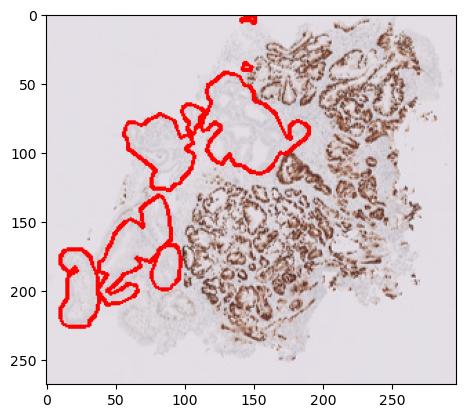

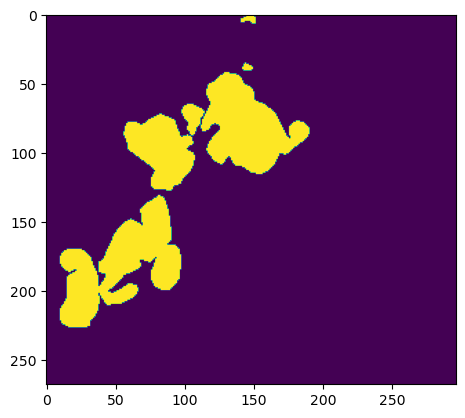

In [11]:
spacing = 8.0

d = LANS_BIOP_DIR
biopsy = biopsies_df.iloc[11] # eg 1 is null, 11 is doubleclones
casename = biopsy["casename"]
print("Dir: ", d)
print("Case: ", casename)
casepaths = cases[casename]

rois = get_rois_for_biopsy(biopsy)
roi_outlines = rois["contour"].copy().tolist()


outline = biopsy["contour"]
area = get_area(outline, spacing) # biopsy area (x,y,w,h) x,y are the top left corner
x,y,w,h = area
x,y = outline.min(axis=0)

wsi = WholeSlideImage(casepaths["wsi"]) # whole slide image
biopsy_img = wsi.get_patch(*area, spacing) # biopsy image

# Correct the roi outline points to be relative to the biopsy
for i in range(len(roi_outlines)):
    roi_outlines[i] = (roi_outlines[i] - [x,y]) / 4 / spacing

    
print(x,y,w,h)
display([ol.mean(axis=0) for ol in roi_outlines])

# Draw the biopsy and the rois
biopsy_img = np.array(biopsy_img)
for roi_outline in roi_outlines:
    roi_outline = roi_outline.astype(int)
    biopsy_img = cv2.drawContours(biopsy_img, [roi_outline], 
        -1,  # draw all contours
        (255,0,0), 
        2 # thickness
    )

mask_img = np.zeros(biopsy_img.shape[:2], np.uint8)
for roi_outline in roi_outlines:
    roi_outline = roi_outline.astype(int)
    mask_img = cv2.drawContours(mask_img, [roi_outline], 
        -1,  # draw all contours
        255, 
        -1 # thickness
    )

# Show
plt.imshow(biopsy_img)
plt.show()
plt.imshow(mask_img)
plt.show()


# Create dataset

In [19]:
spacing = 1.0

CREATE_DATASET = True
if CREATE_DATASET:
    # Iterate through all cases and save the biopsies as pngs
    # Also save a csv with the labels of the biopsies
    destination = os.path.join(LANS_BIOP_ROOT, f"all_biopsies_s{spacing}")
    dest_mask = os.path.join(destination, "masks")
    os.makedirs(dest_mask, exist_ok=True)

    d = LANS_BIOP_DIR
    print("Dir: ", d)
    for casename in tqdm(casenames):
        casepaths = cases[casename]
        wsa = WholeSlideAnnotation(casepaths["wsa"])

        exclusions = ["exclude", "none"]
        labels = []
        outlines = []
        for a, o in zip(wsa.annotations, get_outlines(wsa)):
            if a.label.name in exclusions:
                continue
            labels.append(a.label.name)
            outlines.append(o)

        if "roinullmutation" not in labels:
            continue

        roi_outlines = []
        for b in range(len(labels)):
            if not labels[b] == "roinullmutation":
                continue
            roi_outlines.append(outlines[b])

        for b in range(len(labels)):
            biopsy_name = f"{casename}_b{b}"

            if os.path.exists(os.path.join(dest_mask, f"{biopsy_name}.png")):
                continue

            outline = outlines[b]
            area = get_area(outline, spacing)
            x,y,w,h = area

            # Save rois as binary mask
            if labels[b] in ["nullmutation", "doubleclones"]:
                mask_img = np.zeros((int(h),int(w)), np.uint8)
                x,y = outline.min(axis=0) # top left corner (area[:2] are the middle)
                for roi_outline in roi_outlines:
                    roi_outline = roi_outline - [x,y]
                    roi_outline = roi_outline * 0.25 / spacing
                    roi_outline = roi_outline.astype(int)
                    mask_img = cv2.drawContours(mask_img, [roi_outline], 
                        -1,  # draw all contours
                        255,
                        -1 # thickness (fill)
                    )
                # If mask is empty, skip
                if mask_img.max() == 0:
                    continue
                cv2.imwrite(os.path.join(dest_mask, f"{biopsy_name}.png"), mask_img)

Dir:  L:\\basic\\divg\\PATH-COMPAI\\datasets\\Barrett\\p53_biopsy-level_no-HE_Luuk\_Luuk\biopsy_annotated_slides


  0%|          | 0/615 [00:00<?, ?it/s]

100%|██████████| 615/615 [00:14<00:00, 41.39it/s]


# Prepare data

In [38]:
mapping = {
    "wildtype": 0,
    "overexpression": 1,
    "nullmutation": 2,
    "doubleclones": 3,
    "none": -1,
    "exclude": -1,
    "roinullmutation": -1,
}

In [39]:
if CREATE_DATASET:
    # Iterate through csv that was just created, and map the labels to numbers
    # Also copy the biopsies to a new folder, and rename them to the number of the row in the csv (so 0.png, 1.png etc.)
    print("spacing: ", spacing)

    # Use the saved csv to make a prepared dataset, with one folder containing all biopsies with names like 0.png 1.png etc., and a csv with the labels
    # Open the csv
    df = pd.read_csv(os.path.join(destination, f"biopsy_labels_s{spacing}.csv"), index_col=0)

    # For every file in biopsies_s{}, copy it to biopsies_s{}_anon, and rename it to the number of the row in the csv (so 0.png, 1.png etc.) (NOT the index)
    source = dest_biop
    destination = os.path.join(LANS_BIOP_ROOT, "dataset_fullsize", f"biopsies_s{spacing}_anon_data")
    dest_biop_anon = os.path.join(destination, "biopsies")
    dest_mask_anon = os.path.join(destination, "masks")
    os.makedirs(dest_biop_anon, exist_ok=True)
    os.makedirs(dest_mask_anon, exist_ok=True)

    # Enumerate over the rows in the csv, NOT the index
    df_clean = df.copy().reset_index()
    for i, row in tqdm(df_clean.iterrows(), total=len(df)):
        # Get the biopsy name
        biopsy_name = row["index"]
        # Get the label
        label = row["label"]
        # Get the source path
        source_path = os.path.join(source, f"{biopsy_name}.png")
        # Get the destination path
        destination_path = os.path.join(dest_biop_anon, f"{i}.png")
        # Copy the file
        os.system(f'copy "{source_path}" "{destination_path}"')

        # Get the mask path
        source_path = os.path.join(dest_mask, f"{biopsy_name}.png")
        if os.path.exists(source_path):
            destination_path = os.path.join(dest_mask_anon, f"{i}.png")
            os.system(f'copy "{source_path}" "{destination_path}"')

    # Drop all unnecessary columns, only keeping the index and the label
    df_clean = df_clean.drop(columns=["dir", "casename", "height", "width", "pixels", "index"])

    # Map labels to numbers according to the mapping:
    df_clean["label"] = df_clean["label"].map(mapping)
    # It should be an integer
    df_clean["label"] = df_clean["label"].astype(int)

    # Name the index column "id" and then don't save the index
    df_clean.index.name = "id"
    df_clean.to_csv(os.path.join(destination, f"biopsy_labels_anon_s{spacing}.csv"))

spacing:  1.0


100%|██████████| 1532/1532 [05:29<00:00,  4.64it/s]


In [40]:
spacing = 1.0
destination = os.path.join(LANS_BIOP_ROOT, "dataset_fullsize", f"biopsies_s{spacing}_anon")
saved = set(sorted([int(f.split('.')[0]) for f in os.listdir(destination) if f.endswith('.png')]))

# Check for missing files
required = set(range(len(df)))
missing = list(required.difference(saved))
# Give each row of df a number as index, because right now it's the biopsy name
df_numeric_index = df.reset_index()
print("Missing: ", df_numeric_index.loc[missing])

FileNotFoundError: [WinError 3] Het systeem kan het opgegeven pad niet vinden: 'L:\\\\basic\\\\divg\\\\PATH-COMPAI\\\\datasets\\\\Barrett\\\\p53_experiment_luuk_biopsy-level_no-HE\\dataset_fullsize\\biopsies_s1.0_anon'

In [171]:
# # folder : L:\basic\divg\PATH-COMPAI\datasets\Barrett\p53_experiment_luuk_biopsy-level_no-HE\dataset_fullsize\biopsies_s1.0_data\test
# # Take files from the above folder and reverse the rgb channels and save them in the same folder with the same name
# # Do this for all files in the folder
# import cv2
# import os
# import numpy as np
# from tqdm import tqdm

# folder = r'L:\basic\divg\PATH-COMPAI\datasets\Barrett\p53_experiment_luuk_biopsy-level_no-HE\dataset_fullsize\biopsies_s1.0_data\biopsies'
# files = [f for f in os.listdir(folder) if f.endswith('.png')]
# for f in tqdm(files):
#     path = os.path.join(folder, f)
#     img = cv2.imread(path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     cv2.imwrite(path, img)

100%|██████████| 1532/1532 [28:48<00:00,  1.13s/it]
